### Universidad de Granada | ETSIIT

---
# Identificación única para combatir la desnutrición
---
**HackForGood 2022**


**Equipo 4:**
- Pilar Navarro Ramírez
- Alejandro Alonso Membrilla
- Valentino Lugli

## Montando el Notebook e Importación de Librerías

In [ ]:
# Permitiendo la conexión con Google Drive.
from google.colab import drive
drive.mount('/content/drive')

# Modificar la ruta de ser necesario hasta el zip de "iris-dataset".
path_drive = "/content/drive/MyDrive/hackforgood2022-grx/iris-dataset.zip" 

# Descomprimir los datos en el espacio de Colab.
!unzip -o $path_drive -d "/content/"

Mounted at /content/drive
Archive:  /content/drive/MyDrive/hackforgood2022-grx/iris-dataset.zip
   creating: /content/dataset/
  inflating: /content/dataset/left-diff-sub80.csv  
  inflating: /content/dataset/left-diff-top80.csv  
  inflating: /content/dataset/left-diff.csv  
  inflating: /content/dataset/left-same-sub80.csv  
  inflating: /content/dataset/left-same-top80.csv  
  inflating: /content/dataset/left-same.csv  
   creating: /content/dataset/MMU-Iris-2/
  inflating: /content/dataset/MMU-Iris-2/350205.bmp  
  inflating: /content/dataset/MMU-Iris-2/010101.bmp  
  inflating: /content/dataset/MMU-Iris-2/010102.bmp  
  inflating: /content/dataset/MMU-Iris-2/010103.bmp  
  inflating: /content/dataset/MMU-Iris-2/010104.bmp  
  inflating: /content/dataset/MMU-Iris-2/010105.bmp  
  inflating: /content/dataset/MMU-Iris-2/010201.bmp  
  inflating: /content/dataset/MMU-Iris-2/010202.bmp  
  inflating: /content/dataset/MMU-Iris-2/010203.bmp  
  inflating: /content/dataset/MMU-Iris-2/0102

In [ ]:
#   Usando Random para aleatorizar vectores.
import random
from random import shuffle
#   Usando Numpy para cálculos matriciales.
import numpy as np
#   Usando Matplotlib para mostrar imágenes.
import matplotlib.pyplot as plt
import matplotlib.colors as clr
#   Usando OpenCV para el preprocesado.
import cv2 as cv
#   Usando datetime a la hora de guardar los modelos.
from datetime import datetime
#   Usando Scikit Learn para usar metricas y separar validación de train.
from sklearn import metrics
from sklearn.model_selection import train_test_split
#   Usando Seaborn para la matriz de confusion.
import seaborn as sns

# Keras y Tensorflow para construir la red.
import keras
import tensorflow as tf
from keras.backend import batch_dot
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from keras.utils import np_utils
from keras import callbacks
from keras.engine.input_layer import Input
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ReLU, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Lambda
import tensorflow.keras.backend as backend

# OS para I/O
import os

# Preprocessing

In [ ]:
def apply_clahe(image,crop):
    clahe = cv2.createCLAHE(clipLimit=crop, tileGridSize=(8, 8))
    image= clahe.apply(image)
    return image

def augment(img):
        #print(np.max(img))
        cropped=img[30:210,30:300]
        #print(img.dtype)
        cropped=apply_clahe(cropped, 4.0)
        
        #img = rotation(cropped, 20)    
        #img = brightness(cropped, 0.2, 1.5)

def get_images_vector(list):
    """
    Separa cada la fila imagen;imagen;etiqueta de la lista de parejas en un 
    vector de tres elementos [imagen, imagen, etiqueta].

    Parameters
    ----------
    list : Stringlist
        Vector que contiene las filas imagen;imagen;etiqueta

    Returns
    -------
    img_vec : List
        Devuelve un vector de vectores de tres elementos 
        [imagen, imagen, etiqueta].
    """
    pair_list = open(list,"r")
    img_vec = []

    for line in pair_list:
        sline = line.split(",")
        img_vec.append([sline[0], sline[1], [float(sline[2])]])

    return img_vec

def cached_img_read(img_path, img_shape, image_cache):
    """
    Comprueba que la imagen no haya sido cargada previamente y si no es así
    la carga.

    Parameters
    ----------
    img_path : String
        Ruta de la imagen que se quiere cargar.
    img_shape : TupleOfInt
        Dimensiones objetivo de la imagen.
    img_cache : Dict
        Diccionario de imágenes previamente cargadas.

    Returns
    -------
    image_cache[img_path] : NumpyImage
        Imagen cargada.
    """
    # Se comprueba si la imagen solicitada no se ha leido previamente.
    if img_path not in image_cache.keys():
        # Si no se ha leido previamente debe leerse.
        # Leemos las imágenes en escala de gris.
        # Se escala utilizando interpolación lineal.
        image = img_to_array(load_img(img_path, color_mode="grayscale", target_size=img_shape, interpolation="bilinear")).astype(np.float32)
        image_cache[img_path] = image # Se almacena en el diccionario.
    
    #Devuelve la imagen img_path del diccionario.
    return image_cache[img_path]

def read_images_gen(images, dir, img_shape, datagen, image_cache):
    """
    Carga las imagenes de un batch. Aplica el preprocesa de imagenes con
    cv.Threshold e invierte los valores de las mismas.

    Parameters
    ----------
    images : List
        Lista de los nombres de las imágenes.
    dir : String
        Directorio que contiene la imágenes.
    img_shape : Tuple of Int
        Dimensiones objetivo de la imagen.
    datagen : ImageDataGenerator
        Objeto ImageDataGenerator necesario para aplicar la normalización
        o el aumento de datos (En el caso de realizarla).
    img_cache : Dict
        Diccionario de imágenes previamente cargadas.

    Returns
    -------
    images_vec : NumpyArray
        Vector que contiene las imágenes cargadas.
    """
    # Creamos un vector inicializado a 0 para almacenar las imagenes.
    X = np.zeros((len(images), img_shape[0], img_shape[1], 1))
    # Para cada pareja de la lista.
    for i, image_name in enumerate(images):
        # Leemos la imagen.
        image = cached_img_read(dir+image_name, img_shape, image_cache)
        # Aplicamos el threshold.
        #_, image = cv.threshold(image,220,255,cv.THRESH_BINARY)
        # Invertimos los valores de la imagen.
        #image = (255.0 - image)
        # Eliminamos una dimensión.
        #image = np.expand_dims(image, axis=-1)
        # Estandarizamos la imagen.
        # Si datagen no ha sido previamente entrenado con los
        # valores de entrada para normalizar, no tiene efecto.
        X[i] = datagen.standardize(image)
    return X
        

def image_generator(images, dir, batch_size, datagen, img_shape=(175,272), shuffle=True):
    """
    Generador de imagenes adaptado para redes siamesas.

    Parameters
    ----------
    images : List
        Lista de los nombres de las imágenes.
    dir : String
        Directorio que contiene la imágenes.
    batch_size: Integer
        Tamaño del batch.
    datagen : ImageDataGenerator
        Objeto ImageDataGenerator necesario para aplicar la normalización
        o el aumento de datos (En el caso de realizarla).
    img_shape : Tuple of Int
        Dimensiones objetivo de la imagen.
    shuffle : Boolean
        Variable que activa o desactiva la generación de imagenes en orden 
        aleatorio.

    Returns
    -------
    ([img1, img2], label) : Tuple of List and Float
        Cada llamada al generador devuelve una tupla con dos imagenes
        y una etiqueta
    """
    image_cache = {} # Creamos el diccionario de imagenes leidas.

    while True:
        n_imgs = len(images)
        
        if shuffle:
            indexs = np.random.permutation(np.arange(n_imgs)) # Indices aleatorios.
        else:
            indexs = np.arange(n_imgs)

        num_batches = n_imgs // batch_size

        for bid in range(num_batches):
            # Para cada batch selecciona los indices de las imagenes
            # correspondientes.
            batch_idx = indexs[bid*batch_size:(bid+1)*batch_size]
            # Obtiene los nombres de las imagenes del batch.
            batch = [images[i] for i in batch_idx]
            # Lee la imagen izquierda o 1.
            img1 = read_images_gen([b[0] for b in batch], dir, img_shape, datagen, image_cache)
            # Lee la imagen derecha o 2.
            img2 = read_images_gen([b[1] for b in batch], dir, img_shape, datagen, image_cache)
            # Guarda las etiquetas en un vector.
            label = np.array([b[2] for b in batch]).astype(np.float32) # BINARY
            yield ([img1, img2], label)

# Training

In [ ]:
def mostrarEvolucion(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()

    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training accuracy', 'Validation accuracy'])
    plt.show()


def build_siamese_model(img_shape):
    """
    Genera la arquitectura de la red gemela
    """
    model = Sequential()
    model.add(Conv2D(96, (11,11), activation='relu', input_shape=img_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Conv2D(256, (5,5), strides=(1,1), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Conv2D(384, (3,3), strides=(1,1), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), strides=(1,1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(5,5)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128))

    return model

def euclidean_distance(vectors):
    """
    Calcula la distancia euclidea entre dos vectores
    """
    x, y = vectors
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, backend.epsilon()))

    return distance

def contrastive_loss(y_true, y_pred):
    """
    Calcula la función de pérdida contrastive loss

    Parameters
    ----------
    y_true: 
        Lista de etiquetas.
    y_pred: 
        Lista de etiquetas predecidas.

    Returns
    -------
    Un tensor que contiene el valor de la función de pérdida.
    """
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(1 - (y_pred), 0))
    return tf.math.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)

In [ ]:
# Definición de los parámetros de entrenamiento.
IMG_SHAPE = (238, 320,1)
IMG_WH = (238, 320)
BATCH_SIZE = 32
opt = tf.keras.optimizers.RMSprop(learning_rate=1e-4, momentum=0.9, epsilon=1e-8)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [ ]:
# Definimos la arquitectura compartida de las subredes gemelas.
img1 = Input(shape=IMG_SHAPE)
img2 = Input(shape=IMG_SHAPE)

feature_extractor = build_siamese_model(IMG_SHAPE)
feature_extractor.summary()

features1 = feature_extractor(img1)
features2 = feature_extractor(img2)

distance = Lambda(euclidean_distance)([features1,features2])
outputs = Dense(1, activation="sigmoid") (distance)

model = Model(inputs=[img1, img2], outputs=outputs)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 228, 310, 96)      11712     
                                                                 
 batch_normalization_2 (Batc  (None, 228, 310, 96)     384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 113, 154, 96)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 113, 154, 256)     614656    
                                                                 
 batch_normalization_3 (Batc  (None, 113, 154, 256)    1024      
 hNormalization)                                                 
                                                      

In [ ]:
trainval = get_images_vector("./dataset/train.csv") # Conjunto de Train y validación.
test = get_images_vector("./dataset/test.csv") # Conjunto de Test.

train, val = train_test_split(trainval, train_size=0.75) # Separamos el conjunto de Train y validación.

In [ ]:
datagen = ImageDataGenerator() # Creamos un ImageDataGenerator vacío.

# Creamos los generadores de datos.
datagen_train = image_generator(train, "", BATCH_SIZE, datagen, img_shape=IMG_WH)
print("[INFO]: Train data loaded...")
datagen_val = image_generator(val, "", BATCH_SIZE, datagen, img_shape=IMG_WH)
print("[INFO]: Validation data loaded...")
datagen_test = image_generator(test, "", BATCH_SIZE, datagen, img_shape=IMG_WH)
print("[INFO]: Test data loaded...")

[INFO]: Train data loaded...
[INFO]: Validation data loaded...
[INFO]: Test data loaded...


(180, 270)


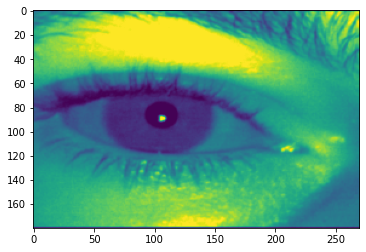

In [ ]:
# Mostrar como se ve una imagen del conjunto de entrenamiento.
for i in datagen_train:
  print(np.squeeze(i[0][0][0]).shape)
  plt.imshow(np.squeeze(i[0][0][0]))
  plt.show()
  break

In [ ]:
# Compilamos el modelo.
print("[INFO]: Compiling model...")
model.compile(loss=contrastive_loss, optimizer=opt, metrics=["accuracy"])

[INFO]: Compiling model...


In [ ]:
now = datetime.now() 
# Utilizamos datetime para guardar los modelos en base a la
# fecha y hora de inicio del entrenamiento de forma que podamos
# diferenciarlos.
print('[INFO]: Start fitting at', now.strftime("%H:%M"))

# Entreamos el modelo.
print("[INFO]: Fitting model...")
history = model.fit(
            datagen_train,
            validation_data=datagen_val,
            epochs=20,
            verbose=1,
            steps_per_epoch=(len(train) // BATCH_SIZE),
            validation_steps=(len(val) // BATCH_SIZE),
            callbacks=[callback]
)
print("[INFO]: Trainnig completed...")

[INFO]: Start fitting at 10:38
[INFO]: Fitting model...
Epoch 1/20
73/73 [==============================] - 97s 1s/step - loss: 0.2082 - accuracy: 0.5009 - val_loss: 0.1932 - val_accuracy: 0.6016
Epoch 2/20
73/73 [==============================] - 83s 1s/step - loss: 0.1954 - accuracy: 0.5706 - val_loss: 0.1947 - val_accuracy: 0.7708
Epoch 3/20
73/73 [==============================] - 83s 1s/step - loss: 0.1861 - accuracy: 0.6657 - val_loss: 0.1790 - val_accuracy: 0.6823
Epoch 4/20
73/73 [==============================] - 83s 1s/step - loss: 0.1789 - accuracy: 0.7247 - val_loss: 0.1839 - val_accuracy: 0.7018
Epoch 5/20
73/73 [==============================] - 83s 1s/step - loss: 0.1707 - accuracy: 0.7680 - val_loss: 0.2012 - val_accuracy: 0.8281
Epoch 6/20
73/73 [==============================] - 83s 1s/step - loss: 0.1607 - accuracy: 0.8074 - val_loss: 0.1610 - val_accuracy: 0.7604
Epoch 7/20
73/73 [==============================] - 83s 1s/step - loss: 0.1549 - accuracy: 0.8438 - val_

25/25 - 8s - loss: 0.1275 - accuracy: 0.8425 - 8s/epoch - 336ms/step


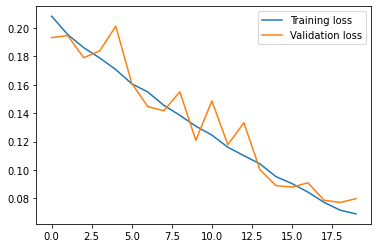

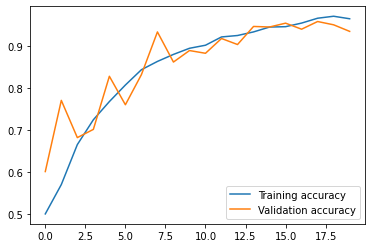

In [ ]:
# Guardamos el modelo.
# Y que no es necesario se incluye comentado.
#model_name = "./model_"+ now.strftime("%d_%m_%H_%M") + ".h5"
#model.save(model_name)
#os.system("cp {} /content/drive/MyDrive/hackforgood2022-grx/".format(model_name))

# Finalmente evaluamos el modelo entrenado en el conjunto Test.
model.evaluate(
            datagen_test,
            batch_size=BATCH_SIZE,
            verbose=2,
            steps= len(test)/BATCH_SIZE
)

mostrarEvolucion(history) # Mostramos las gráficas de aprendizaje.

# Validación

In [ ]:
# Utilizar esta celda si se carga un modelo guardado
"""
img1 = Input(shape=IMG_SHAPE)
img2 = Input(shape=IMG_SHAPE)

feature_extractor = build_siamese_model(IMG_SHAPE)

features1 = feature_extractor(img1)
features2 = feature_extractor(img2)

distance = Lambda(euclidean_distance)([features1,features2])
outputs = Dense(1, activation="sigmoid") (distance)

model_load = Model(inputs=[img1, img2], outputs=outputs)

# Cambiar la ruta de ser necesario
model_load.load_weights('/content/drive/MyDrive/hackforgood2022-grx/pesos-modelo-iris.h5')
"""

In [ ]:
def test_validation_gen():
  """
  Definimos un generador secuencial de imagenes del conjunto de test
  para poder utilizarlo en la funcion predict de manera eficiente.
  El preprocesado de datos es igual que en el generador anterior.
  """
  for img in test:
    path = img[0]
    image = img_to_array(load_img(path, color_mode="grayscale", target_size=IMG_WH, interpolation="bilinear")).astype(np.float32)
    #_, image = cv.threshold(image,220,255,cv.THRESH_BINARY)
    #image = (255.0 - image)
    image1 = np.expand_dims(image, axis=0)

    path = img[1]
    image = img_to_array(load_img(path, color_mode="grayscale", target_size=IMG_WH, interpolation="bilinear")).astype(np.float32)
    #_, image = cv.threshold(image,220,255,cv.THRESH_BINARY)
    #image = (255.0 - image)
    image2 = np.expand_dims(image, axis=0)

    label = np.array(img[2])
    yield ([image1, image2], label)

800/800 [==============================] - 17s 20ms/step


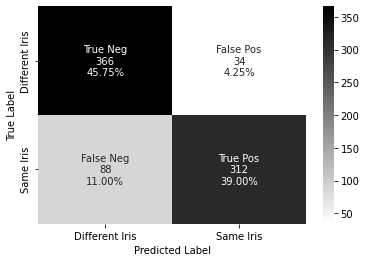

Accuracy: 0.8475
Precision: 0.9017341040462428
Recall: 0.78


In [ ]:
images = []
y_test = []

datagen = test_validation_gen()

# Utilizamos el modelo entrenado para predecir las etiquetal de los datos
# del conjunto de Test.
y_prob = model_load.predict(
    datagen,
    verbose = 1,
    steps=len(test))

for img in test:
  y_test.append(img[2])

# Simplificamos el vector de predicciones de manera que si
# la etiqueta es mayor de 0.5 esta pasa a ser 1 y si no es 0.
# La gestión de colab de las operaciones de comparación en coma flotante 
# difiere de la gestion de nuestra librerias locales (probablemente por la
# diferencia de versiones). Por esto las métricas obtenidas en colab son 
# diferentes a las obtenidas en local (las diferencias no son significativas).
for i,pred in enumerate(y_prob):
  if pred > 0.5:
      y_prob[i] = [1.0]
  else:
      y_prob[i] = [0.0]

# Pasamos las etiquetas de Binary a Categorical para poder obtener la matriz
# de confusión.
y_prob=np.array(y_prob)
y_prob = np_utils.to_categorical(y_prob)
y_test=np.array(y_test)
y_test = np_utils.to_categorical(y_test)

# Obtenemos la matriz de confusión.
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_prob.argmax(axis=1), labels=[0.0, 1.0])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in matrix.flatten()/np.sum(matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ticklabels = ['Different Iris', 'Same Iris']
ax = sns.heatmap(matrix, annot=labels, xticklabels=ticklabels, yticklabels=ticklabels, fmt='', cmap='binary')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Imprimimos las metricas calculadas con scikit-learn.
print("Accuracy:", metrics.accuracy_score(y_test, y_prob))
print("Precision:", metrics.precision_score(y_test.argmax(axis=1), y_prob.argmax(axis=1)))
print("Recall:", metrics.recall_score(y_test.argmax(axis=1), y_prob.argmax(axis=1)))
